# Clustering whole corpus

In [68]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from stop_words import get_stop_words
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, Normalizer

from yellowbrick.text import UMAPVisualizer
from yellowbrick.style import set_palette

from utils import add_epoch_division, linkage_matrix, merge_corpus_poets, plot_dendrogram, remove_noise_poet, text_cleaning

In [85]:
LOWERCASE = True
MAX_FEATURES = 10000
NOISELESS = True
if NOISELESS:
    PATH = "../corpora/amann_poems_noiseless.csv"
else:
    PATH = "../corpora/amann_poems.csv"
DIM_RED = False
STOP_WORDS = get_stop_words("de")

In [70]:
# amann
corpus = text_cleaning(pd.read_csv(PATH))

In [71]:
text = corpus["poem"].values
labels = LabelEncoder().fit_transform(corpus["epoch"].values)
unique_epochs = list(np.unique(corpus["epoch"]))


vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(text)

In [72]:
if DIM_RED:
    dim_red = TruncatedSVD(n_components=3)
    normalizer = Normalizer(copy=False)
    pipeline = make_pipeline(dim_red, normalizer)
    vector = pipeline.fit_transform(vector)
    #dim_red = PCA(n_components=7)
    #vector = dim_red.fit_transform(vector.todense())

# Kmeans

In [81]:
kmeans = KMeans(len(unique_epochs))
kmeans.fit(vector)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [82]:
kmeans_ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Score for K-Means: {kmeans_ari}.")

kmeans_vm = v_measure_score(labels, kmeans.labels_)
print(f"V-measure for K-Means: {kmeans_vm}.")

Adjusted Rand Score for K-Means: 0.27339627292524654.
V-measure for K-Means: 0.4253396647121405.


In [83]:
unique_labels = ["Barock", "Aufklärung", "Sturm_Drang", "Klassik", "Romantik", 
                 "Biedermeier", "Realismus", "Naturalismus", "Expressionismus"]

#### K-Means

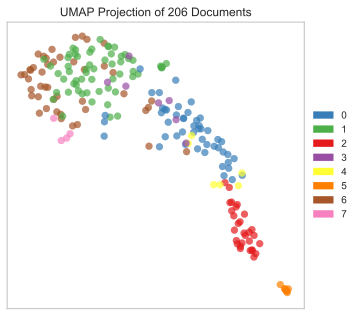

In [92]:
set_palette('set1')
umap = UMAPVisualizer(size=(480, 380))
#umap.fit(vector, list(corpus.epoch))
umap.fit(vector, kmeans.labels_)
if DIM_RED:
    figure_name = "amann_all_epochs_kmeans_rd"
else:
    if NOISELESS:
        figure_name = "amann_all_epochs_noiseless_kmeans"
    else:
        figure_name = "amann_all_epochs_kmeans"
        
figure_path = f"../results/figures/whole_corpus/{figure_name}.png"
#umap.show()
umap.show(outpath=figure_path, dpi=350)

#### original

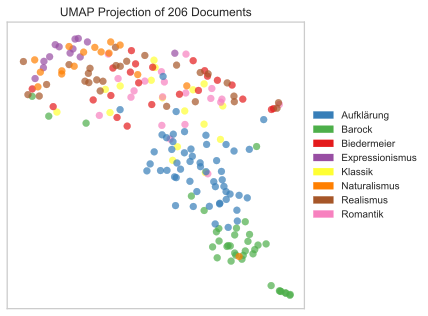

In [87]:
set_palette('set1')
umap = UMAPVisualizer(size=(480, 380))
umap.fit(vector, list(corpus.epoch))
if DIM_RED:
    figure_name = "amann_all_epochs_rd"
else:
    if NOISELESS:
        figure_name = "amann_all_epochs_noiseless"
    else:
        figure_name = "amann_all_epochs"
figure_path = f"../results/figures/whole_corpus/{figure_name}.png"
#umap.show()
umap.show(outpath=figure_path, dpi=350)